In [206]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.font_manager
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from datetime import datetime, timedelta

#sklearn functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

from utils import utils
import matplotlib.patches as mpatches 

import warnings

warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow_probability as tfp 

tfd = tfp.distributions

from utils import utils
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d

In [ ]:
#import data
#get data and visualize them
ticker = yf.Ticker('SPY')
df =ticker.history(interval = '1h', period = '1y')

#rename the index and reset it
df = df.rename_axis("Date").reset_index()

#make columns lowercase
df.columns = [x.lower() for x in df.columns]

[*********************100%***********************]  1 of 1 completed


In [11]:
#create targets
df = utils.create_targets(df, target_winloss = [10, 0])

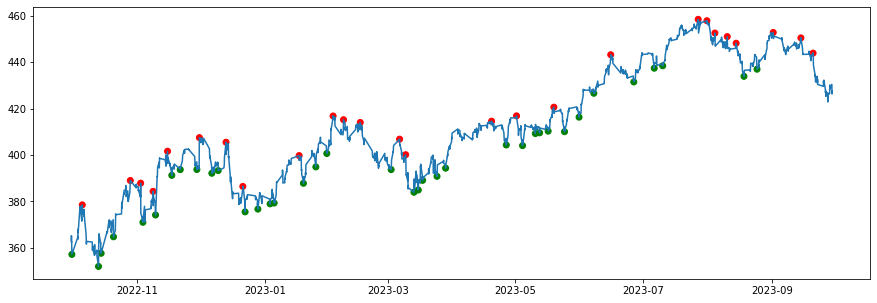

In [12]:
#plot the results
colors = {0: 'None', 1: 'green', 2: 'red'}

plt.figure(figsize = (15, 5))
plt.plot(df['date'], df['close'])
plt.scatter(df['date'], df['close'], c = df['target'].apply(lambda x: colors[x]))
plt.show()

In [13]:
#filter out the targets in between
df['target2'] = df['target']

#current target
curr = df['target'].iloc[0]

for i, row in df[1:].iterrows():
    
    if (curr == row.target):
        df['target2'][i] = 0
        curr = row.target
    elif (curr != row.target) and (row.target == 0):
        df['target2'][i] = 0     
    elif (curr != row.target) and (row.target == 1):
        df['target2'][i] = 1
        curr = row.target
    elif (curr != row.target) and (row.target == 2):
        df['target2'][i] = 2
        curr = row.target
    else:
        df['target2'][i] = 0
        


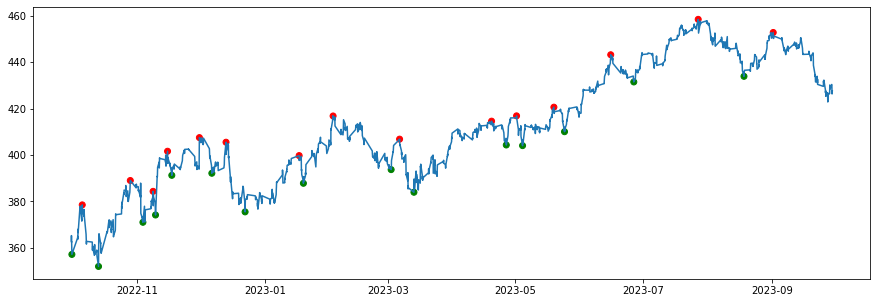

0    1720
1      15
2      15
Name: target2, dtype: int64


In [19]:
#plot the target2
#plot the results
colors = {0: 'None', 1: 'green', 2: 'red'}

plt.figure(figsize = (15, 5))
plt.plot(df['date'], df['close'])
plt.scatter(df['date'], df['close'], c = df['target2'].apply(lambda x: colors[x]))
plt.show()

#value counts
print(f"{df['target2'].value_counts()}")

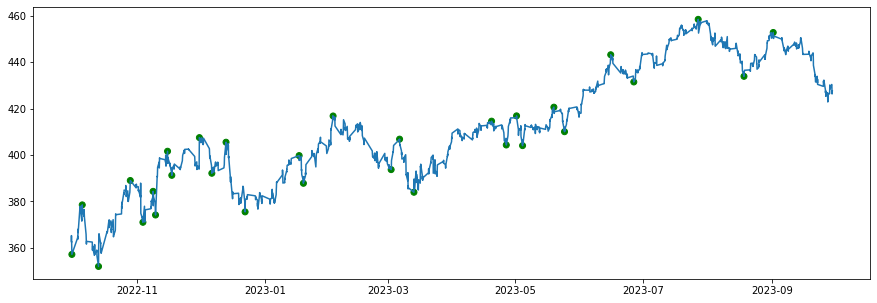

In [21]:
#set 1's and 2's as outliers
df['outliers'] = [1 if x > 0 else 0 for x in df['target2']]

#plot 
colors = {0: 'None', 1: 'green'}

plt.figure(figsize = (15, 5))
plt.plot(df['date'], df['close'])
plt.scatter(df['date'], df['close'], c = df['outliers'].apply(lambda x: colors[x]))
plt.show()

In [25]:
#calculate rsi, ema and sma values

#create sma
df['sma'] = df['close'].rolling(30).mean()

ema_period = 40
df['ema'] = df['sma'].ewm(ema_period, adjust = False).mean()

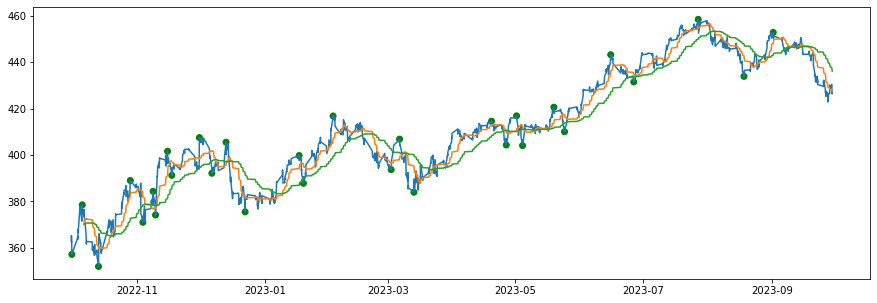

In [27]:
#plot everything
colors = {0: 'None', 1: 'green'}

plt.figure(figsize = (15, 5))
plt.plot(df['date'], df['close'])
plt.scatter(df['date'], df['close'], c = df['outliers'].apply(lambda x: colors[x]))
plt.plot(df['date'], df['sma'], label = 'SMA')
plt.plot(df['date'], df['ema'], label = 'EMA')
plt.show()

In [37]:
#create a dataset with open, high, low, close, ema, sma, volume to predict if a data point is an outlier
int_cols = ['open', 'high', 'low', 'close', 'ema', 'sma', 'volume', 'outliers']

#training set with outliers
train_outs = df[df['outliers'] == 1][int_cols].dropna()

#sample datapoints that are not outliers. Doing this because there are too many of these points
train_noouts = df[df['outliers'] == 0][int_cols].dropna().sample(n = 30, random_state = 42)

#combine them and shuffle the rows
combined_df = pd.concat([train_outs, train_noouts], ignore_index = True)

train_df = combined_df.sample(frac = 1, random_state = 42).reset_index(drop = True)

#print new dataframe
train_df.head()

,open,high,low,close,ema,sma,volume,outliers
0,349.204987,354.140900,348.109985,352.000000,368.768514,360.554036,37857917,1
1,401.149994,402.309998,399.970001,401.600006,381.175413,391.063353,17265650,1
2,442.609985,443.089996,439.790009,440.119995,448.837472,444.864693,11926468,0
3,415.250000,416.799988,414.649994,416.779999,399.513002,407.152066,14353649,1
4,389.015015,389.519989,388.630005,388.989990,372.764458,383.744933,12678410,0


In [102]:
#create a training set
X_train = train_df[['open', 'high', 'low', 'close', 'ema', 'sma', 'volume']].to_numpy().reshape(-1, 7)
y_train = train_df['outliers'].to_numpy().reshape(-1, 1)

#scale the training dataset
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled = X_train_scaled.reshape(-1, 1, 7)
X_train_scaled.shape

(58, 1, 7)

In [103]:
#build the model
kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
                            tf.cast(len(X_train), dtype=tf.float32))

input_layer = tf.keras.layers.Input(shape = (1, 7))
dense_layer = tfp.layers.DenseFlipout(
    units = 1,
    activation = 'sigmoid', 
    kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    kernel_divergence_fn=kl_divergence_function)(input_layer)


model = tf.keras.Model(inputs = input_layer, outputs = dense_layer)
optimizer = tf.keras.optimizers.Adam(lr=0.01)
model.compile(optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')

In [104]:
history = model.fit(X_train_scaled, y_train, epochs = 50, verbose=False)


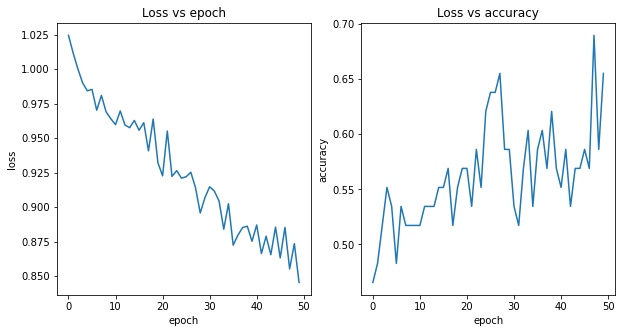

In [105]:
#plot accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

ax1.plot(history.history['loss'])
ax1.set_title('Loss vs epoch')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')

ax2.plot(history.history['accuracy'])
ax2.set_title('Loss vs accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
plt.show()


In [92]:
#sample results from the model
yhats = [model(X_train_scaled) for _ in range(100)]

In [183]:
#get results from yhats
results = np.empty((len(X_train), 0))

#get model weights
w = model.weights[0].numpy()
b = model.weights[2].numpy()

#create results df
results_df = pd.DataFrame(columns = ['xval', 'mean_prob', 'std', 'outlier'])

for i in range(len(X_train_scaled)):
    
    prob_dist = [np.squeeze(model(X_train_scaled[i].reshape(-1, 1, 7))) for _ in range(100)]
    
    #calculate the values
    xval = X_train_scaled[i] @ w + b
    prob_mean = np.mean(prob_dist)
    prob_std = np.std(prob_dist)
    
    data_dict = {
        'xval': np.squeeze(xval),
        'mean_prob': prob_mean,
        'std': prob_std
    }
    
    results_df = results_df.append(data_dict, ignore_index = True)

In [190]:
#create the std+ and std- values
results_df['outlier'] = train_df['outliers']
results_df['prob_high'] = results_df['mean_prob'] + results_df['std']
results_df['prob_low'] = results_df['mean_prob'] - results_df['std']

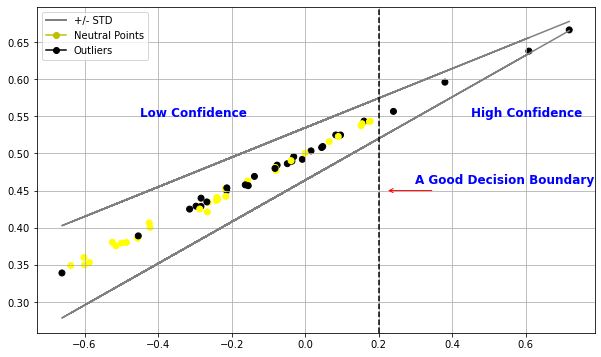

In [270]:
from scipy.stats import linregress

#colors
colors = {0: 'yellow', 1: 'k'}

#for plotting purposes
mean_probs = results_df['mean_prob'].astype(float)
minus_std = results_df['prob_low'].astype(float)
plus_std = results_df['prob_high'].astype(float)
xvals = results_df['xval'].astype(float)

slope, intercept, r_value, p_value, std_err = linregress(xvals, minus_std)
regression_line_minus = slope * xvals + intercept

slope, intercept, r_value, p_value, std_err = linregress(xvals, plus_std)
regression_line_plus = slope * xvals + intercept

plt.figure(figsize = (10, 6))
plt.scatter(xvals, mean_probs, c = results_df['outlier'].apply(lambda x: colors[x]))
plt.plot(xvals, regression_line_plus, c = 'gray')
plt.plot(xvals, regression_line_minus, c = 'gray')
plt.axvline(0.2, c = 'k', linestyle = '--')
plt.grid(True)

legend_labels = ['+/- STD', 'Neutral Points', 'Outliers']

legend_elements = [plt.Line2D([0], [0], color = 'gray', lw = 2), plt.Line2D([1], [0], marker = 'o', color = 'y'),
                  plt.Line2D([2], [0], marker = 'o', color = 'k')]

plt.annotate('High Confidence', xy = (0.45, 0.55), fontsize = 12, color = 'blue', weight = 'bold')
plt.annotate('Low Confidence', xy = (-0.45, 0.55), fontsize = 12, color = 'blue', weight = 'bold')


# Define the coordinates for the arrow and text
arrow_x = 0.22
arrow_y = 0.45
text_x = 0.35
text_y = 0.45
arrow_properties = dict(arrowstyle='->', color='red')

# Add an arrow pointing to the specified location
plt.annotate('', xy=(arrow_x, arrow_y), xytext=(text_x, text_y), arrowprops=arrow_properties)

# Add text at the specified location
plt.annotate('A Good Decision Boundary', xy=(text_x, text_y), xytext=(text_x - 0.05, text_y + 0.01),
             fontsize=12, color='blue', weight='bold')


plt.legend(legend_elements, legend_labels)
plt.show()

